https://cmustatistics.github.io/data-repository/money/ames-housing.html

https://cmustatistics.github.io/data-repository/data/ames-housing-DataDocumentation.txt

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
%matplotlib inline

Data Loading

In [54]:
from pathlib import Path

data_path = Path('data/ames-housing.csv')
df = pd.read_csv(data_path)
original_df = df.copy()
print("Dataset Shape: ", df.shape)
df.head()

Dataset Shape:  (2930, 82)


,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [55]:
df.drop(columns=['Order', 'PID'], inplace=True)

# Create new features
df['Years_Since_Built'] = df['Yr.Sold'] - df['Year.Built']
df['Years_Since_Remodel'] = df['Yr.Sold'] - df['Year.Remod.Add']
df['Total_Bathrooms'] = df['Full.Bath'] + 0.5 * df['Half.Bath']
df['Overall_Score'] = df['Overall.Qual'] * df['Overall.Cond']
df['Total_Porch_Area'] = df['Open.Porch.SF'] + df['Enclosed.Porch'] + df['Screen.Porch']
#df.head()


Data exploration

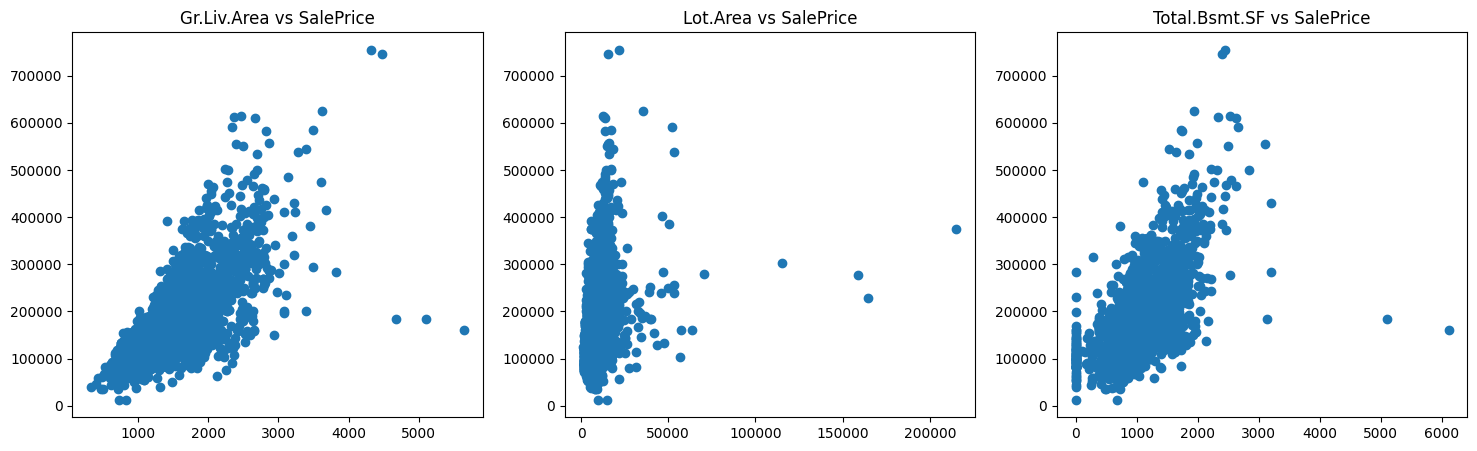

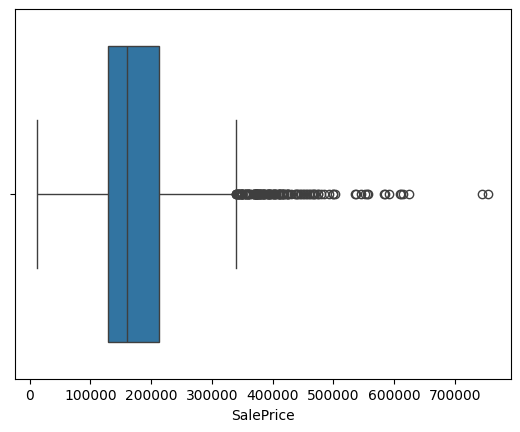

In [56]:
# Inspect outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df['Gr.Liv.Area'], df['SalePrice'])
axes[0].set_title("Gr.Liv.Area vs SalePrice")

axes[1].scatter(df['Lot.Area'], df['SalePrice'])
axes[1].set_title("Lot.Area vs SalePrice")

axes[2].scatter(df['Total.Bsmt.SF'], df['SalePrice'])
axes[2].set_title("Total.Bsmt.SF vs SalePrice")

plt.show()

#sns.scatterplot(x=df['Gr.Liv.Area'], y=df['SalePrice'])
#plt.show()

# Boxplot for SalePrice
sns.boxplot(x=df['SalePrice'])
plt.show()


Preprocesing

In [57]:
# Remove extreme SalePrice values
lower_limit = df['SalePrice'].quantile(0.05)
upper_limit = df['SalePrice'].quantile(0.95)

df = df[(df['SalePrice'] >= lower_limit) & (df['SalePrice'] <= upper_limit)]

# Remove extremely large houses with low sale price
df = df[~((df['Gr.Liv.Area'] > 4000) & (df['SalePrice'] < 300000))]

# Remove very cheap houses
df = df[df['SalePrice'] > 50000]

# Cap LotArea
df = df[df['Lot.Area'] < 100000]

In [58]:
# Get a summary of missing values
missing_values = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100

# Create a DataFrame for missing values info
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percent Missing': missing_values_percent
})

# Sort and show only columns that actually have missing values
missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values('Percent Missing', ascending=False)
print("Columns with Missing Values:")
print(missing_info)
print("\n" + "="*50 + "\n")

Columns with Missing Values:
                Missing Values  Percent Missing
Pool.QC                   2624        99.620349
Misc.Feature              2538        96.355353
Alley                     2454        93.166287
Fence                     2092        79.422931
Mas.Vnr.Type              1616        61.351557
Fireplace.Qu              1283        48.709188
Lot.Frontage               472        17.919514
Garage.Finish              106         4.024298
Garage.Yr.Blt              106         4.024298
Garage.Cond                106         4.024298
Garage.Qual                106         4.024298
Garage.Type                104         3.948368
Bsmt.Exposure               60         2.277904
BsmtFin.Type.2              58         2.201974
Bsmt.Qual                   57         2.164009
BsmtFin.Type.1              57         2.164009
Bsmt.Cond                   57         2.164009
Mas.Vnr.Area                20         0.759301
Electrical                   1         0.037965
Bsmt.Half.B

In [59]:
# Define categorical variables based on the documentation
nominal_vars = [
    'MS.SubClass',    # Identifies type of dwelling (20, 30, 40, etc.)
    'MS.Zoning',      # General zoning classification
    'Street',        # Type of road access
    'Alley',         # Type of alley access
    'Land.Contour',   # Flatness of property
    'Lot.Config',     # Lot configuration
    'Neighborhood',  # Physical locations
    'Condition.1',    # Proximity to conditions
    'Condition.2',    # Proximity to conditions (if multiple)
    'Bldg.Type',      # Type of dwelling
    'House.Style',    # Style of dwelling
    'Roof.Style',     # Type of roof
    'Roof.Matl',      # Roof material
    'Exterior.1st',   # Exterior covering
    'Exterior.2nd',   # Exterior covering (if multiple)
    'Mas.Vnr.Type',    # Masonry veneer type
    'Foundation',    # Type of foundation
    'Heating',       # Type of heating
    'Central.Air',    # Central air conditioning
    'Garage.Type',    # Garage location
    'Misc.Feature',   # Miscellaneous features
    'Sale.Type',      # Type of sale
    'Sale.Condition'  # Condition of sale
]

ordinal_vars = [
    'Lot.Shape',      # General shape of property
    'Utilities',     # Type of utilities available
    'Land.Slope',     # Slope of property
    'Overall.Qual',   # Overall material/finish quality
    'Overall.Cond',   # Overall condition
    'Exter.Qual',     # Exterior material quality
    'Exter.Cond',     # Exterior condition
    'Bsmt.Qual',      # Basement height quality
    'Bsmt.Cond',      # Basement condition
    'Bsmt.Exposure',  # Basement exposure
    'BsmtFin.Type.1',  # Basement finished area rating
    'BsmtFin.Type.2',  # Basement finished area rating (if multiple)
    'Heating.QC',     # Heating quality/condition
    'Electrical',    # Electrical system
    'Kitchen.Qual',   # Kitchen quality
    'Functional',    # Home functionality
    'Fireplace.Qu',   # Fireplace quality
    'Garage.Finish',  # Garage interior finish
    'Garage.Qual',    # Garage quality
    'Garage.Cond',    # Garage condition
    'Paved.Drive',    # Paved driveway
    'Pool.QC',        # Pool quality
    'Fence'          # Fence quality
]

# Discrete variables (should remain numeric but might need special treatment)
discrete_vars = [
    'Order',          # Observation number
    'Year.Built',      # Construction date
    'Year.Remod.Add',   # Remodel date
    'Bsmt.Full.Bath',   # Basement full bathrooms
    'Bsmt.Half.Bath',   # Basement half bathrooms
    'Full.Bath',       # Full bathrooms above grade
    'Half.Bath',       # Half baths above grade
    'Bedroom.AbvGr',   # Bedrooms above grade
    'Kitchen.AbvGr',   # Kitchens above grade
    'TotRms.AbvGrd',   # Total rooms above grade
    'Fireplaces',     # Number of fireplaces
    'Garage.Yr.Blt',    # Year garage built
    'Garage.Cars',     # Garage car capacity
    'Mo.Sold',         # Month sold
    'Yr.Sold'          # Year sold
]

# Continuous variables (should remain numeric)
continuous_vars = [
    'Lot.Frontage',    # Linear feet of street
    'Lot.Area',        # Lot size in square feet
    'Mas.Vnr.Area',     # Masonry veneer area
    'BsmtFin.SF.1',     # Type 1 finished basement area
    'BsmtFin.SF.2',     # Type 2 finished basement area
    'Bsmt.Unf.SF',      # Unfinished basement area
    'Total.Bsmt.SF',    # Total basement area
    'X1st.Flr.SF',       # First floor square feet
    'X2nd.Flr.SF',       # Second floor square feet
    'Low.Qual.Fin.SF',   # Low quality finished area
    'Gr.Liv.Area',      # Above grade living area
    'Garage.Area',     # Garage area
    'Wood.Deck.SF',     # Wood deck area
    'Open.Porch.SF',    # Open porch area
    'Enclosed.Porch',  # Enclosed porch area
    'X3Ssn.Porch',      # Three season porch
    'Screen.Porch',    # Screen porch area
    'Pool.Area',       # Pool area
    'Misc.Val',        # Value of miscellaneous feature
    'SalePrice'       # Sale price
]

# Special handling for ID variables
id_vars = ['PID']  # Parcel ID - should be dropped

print(f"Nominal variables: {len(nominal_vars)}")
print(f"Ordinal variables: {len(ordinal_vars)}")
print(f"Discrete variables: {len(discrete_vars)}")
print(f"Continuous variables: {len(continuous_vars)}")

Nominal variables: 23
Ordinal variables: 23
Discrete variables: 15
Continuous variables: 20


In [60]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Create custom ordinal mappings based on documentation
ordinal_mappings = {
    'Lot.Shape': ['Reg', 'IR1', 'IR2', 'IR3'],  # Regular to Irregular
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # Worst to Best
    'Land.Slope': ['Sev', 'Mod', 'Gtl'],  # Severe to Gentle
    'Overall.Qual': list(range(1, 11)),  # 1 (Very Poor) to 10 (Very Excellent)
    'Overall.Cond': list(range(1, 11)),  # 1 (Very Poor) to 10 (Very Excellent)
    'Exter.Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Poor to Excellent
    'Exter.Cond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Poor to Excellent
    'Bsmt.Qual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # No basement to Excellent
    'Bsmt.Cond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # No basement to Excellent
    'Bsmt.Exposure': ['NA', 'No', 'Mn', 'Av', 'Gd'],  # No exposure to Good
    'BsmtFin.Type.1': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Unfinished to Good Living
    'BsmtFin.Type.2': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Unfinished to Good Living
    'Heating.QC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Poor to Excellent
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # Worst to Best
    'Kitchen.Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Poor to Excellent
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Salvage to Typical
    'Fireplace.Qu': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # No fireplace to Excellent
    'Garage.Finish': ['NA', 'Unf', 'RFn', 'Fin'],  # No garage to Finished
    'Garage.Qual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # No garage to Excellent
    'Garage.Cond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # No garage to Excellent
    'Paved.Drive': ['N', 'P', 'Y'],  # Dirt to Paved
    'Pool.QC': ['NA', 'Fa', 'TA', 'Gd', 'Ex'],  # No pool to Excellent
    'Fence': ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']  # No fence to Good Privacy
}

# Encode nominal variables with label encoding
label_encoder = LabelEncoder()
for col in nominal_vars:
    if col in df.columns:
        # Handle missing values first (convert to string 'Missing')
        df[col] = df[col].fillna('Missing').astype(str)
        df[col] = label_encoder.fit_transform(df[col])

# Encode ordinal variables with custom mappings
for col, categories in ordinal_mappings.items():
    if col in df.columns:
        # Create mapping dictionary
        mapping = {cat: idx for idx, cat in enumerate(categories)}
        # Handle missing values (map to appropriate category)
        df[col] = df[col].fillna('NA' if 'NA' in categories else categories[0])
        df[col] = df[col].map(mapping)

print("All categorical variables have been properly encoded based on documentation")
print(df.info())

All categorical variables have been properly encoded based on documentation
<class 'pandas.core.frame.DataFrame'>
Index: 2634 entries, 0 to 2929
Data columns (total 85 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MS.SubClass          2634 non-null   int64  
 1   MS.Zoning            2634 non-null   int64  
 2   Lot.Frontage         2162 non-null   float64
 3   Lot.Area             2634 non-null   int64  
 4   Street               2634 non-null   int64  
 5   Alley                2634 non-null   int64  
 6   Lot.Shape            2634 non-null   int64  
 7   Land.Contour         2634 non-null   int64  
 8   Utilities            2634 non-null   int64  
 9   Lot.Config           2634 non-null   int64  
 10  Land.Slope           2634 non-null   int64  
 11  Neighborhood         2634 non-null   int64  
 12  Condition.1          2634 non-null   int64  
 13  Condition.2          2634 non-null   int64  
 14  Bldg.Type        

Modeling

In [61]:
# Prepare features and target from the encoded DataFrame
X = df.drop('SalePrice', axis=1).values  # All columns as features - except SalePrice
y = df['SalePrice'].values               # Only SalePrice column as target

print("Features shape: ", X.shape)
print("Target shape: ", y.shape)

Features shape:  (2634, 84)
Target shape:  (2634,)


In [62]:
# Check for missing values in X
print("Missing values in X:", np.isnan(X).sum())

Missing values in X: 602


In [63]:
# If there are missing values, impute them
from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='mean')
#imputer = SimpleImputer(strategy='most_frequent')
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)
print("Missing values in X:", np.isnan(X).sum())

Missing values in X: 0


In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [65]:
# Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test set

In [66]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training and evaluation with Ridge and GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

# Initialize Ridge regression
ridge = Ridge()

# Perform grid search
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get best model
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test_scaled)

In [67]:
# Model Evaluation function
def evaluate_model(y_true, y_pred, model_name="Ridge Regression"):
    """Comprehensive evaluation function for regression models"""
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate percentage error
    percentage_error = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Create evaluation dataframe
    eval_df = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE', 'R²', 'Mean Percentage Error'],
        'Value': [mse, rmse, mae, mape, r2, percentage_error],
        'Description': [
            'Mean Squared Error (lower is better)',
            'Root Mean Squared Error (lower is better)',
            'Mean Absolute Error (lower is better)',
            'Mean Absolute Percentage Error (lower is better)',
            'R-squared (higher is better, max 1.0)',
            'Average percentage error (lower is better)'
        ]
    })
    
    print(f"=== {model_name} Evaluation ===")
    print(f"Best alpha: {grid_search.best_params_}")
    print(f"Cross-validation R²: {grid_search.best_score_:.4f}")
    print("\nTest Set Performance:")
    for _, row in eval_df.iterrows():
        print(f"{row['Metric']}: {row['Value']:.4f} - {row['Description']}")
    
    return eval_df


Evaluation

=== Ridge Regression Evaluation ===
Best alpha: {'alpha': 100.0}
Cross-validation R²: 0.8786

Test Set Performance:
MSE: 365165454.8262 - Mean Squared Error (lower is better)
RMSE: 19109.3028 - Root Mean Squared Error (lower is better)
MAE: 13912.6441 - Mean Absolute Error (lower is better)
MAPE: 0.0834 - Mean Absolute Percentage Error (lower is better)
R²: 0.8853 - R-squared (higher is better, max 1.0)
Mean Percentage Error: 8.3404 - Average percentage error (lower is better)


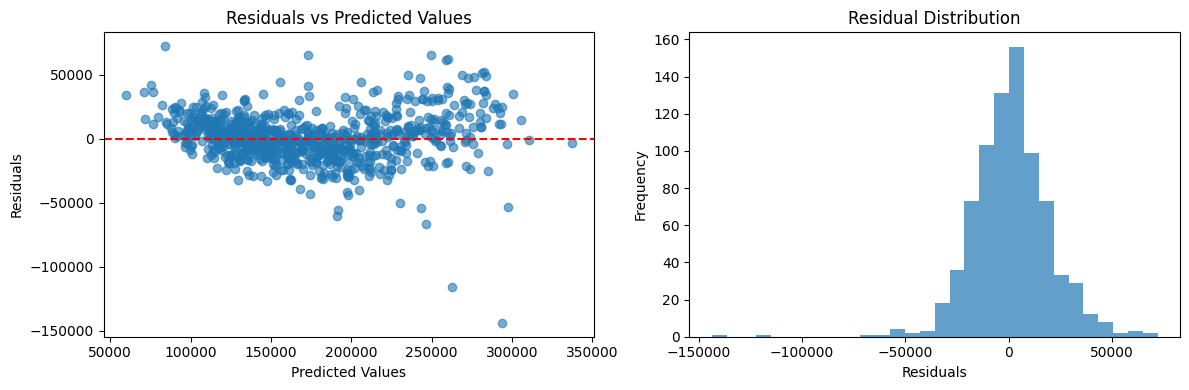

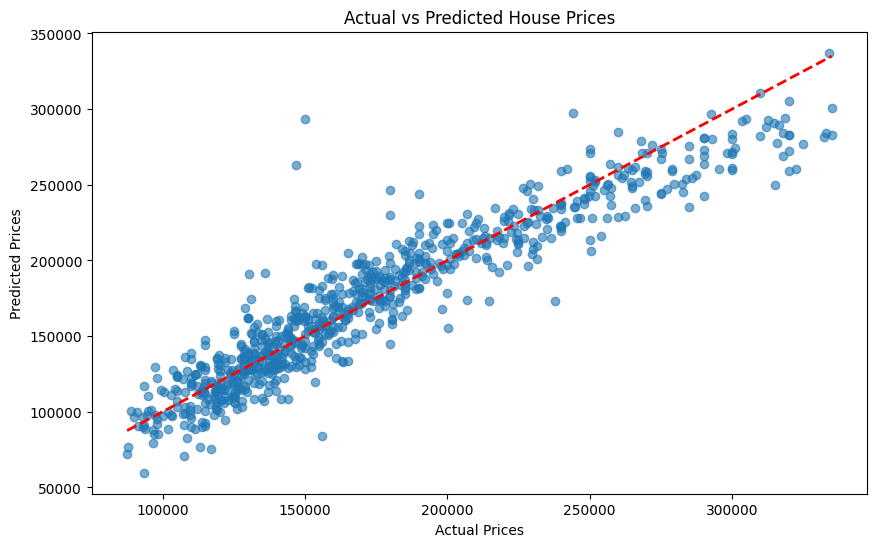

In [68]:
# Evaluate the model
metrics_df = evaluate_model(y_test, y_pred)

# --- RESIDUAL ANALYSIS ---
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(12, 4))

# Residuals vs Predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# Residual distribution
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

plt.tight_layout()
plt.show()

# --- ACTUAL VS PREDICTED PLOT ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.show()

=== RIDGE REGRESSION FEATURE SELECTION ===
Total features: 84
Selected features (coefficient ≥ 1173.9137): 38
Non-selected features: 46
Threshold: 10% of maximum coefficient value (11739.1374)

--- SELECTED FEATURES (Most Influential) ---
          Feature  Coefficient  Abs_Coefficient
      Gr.Liv.Area 11739.137392     11739.137392
      X2nd.Flr.SF  7153.269335      7153.269335
     Overall.Qual  6668.426925      6668.426925
      X1st.Flr.SF  6240.683637      6240.683637
    Total.Bsmt.SF  5482.712401      5482.712401
    Overall_Score  5328.396306      5328.396306
     BsmtFin.SF.1  4925.384173      4925.384173
       Exter.Qual  4052.460797      4052.460797
         Lot.Area  3848.320321      3848.320321
Years_Since_Built -3803.473287      3803.473287
       Year.Built  3773.180349      3773.180349
      Garage.Area  3605.399260      3605.399260
        Bldg.Type -2749.880033      2749.880033
       Fireplaces  2737.868202      2737.868202
    Bedroom.AbvGr -2727.543102      2727.

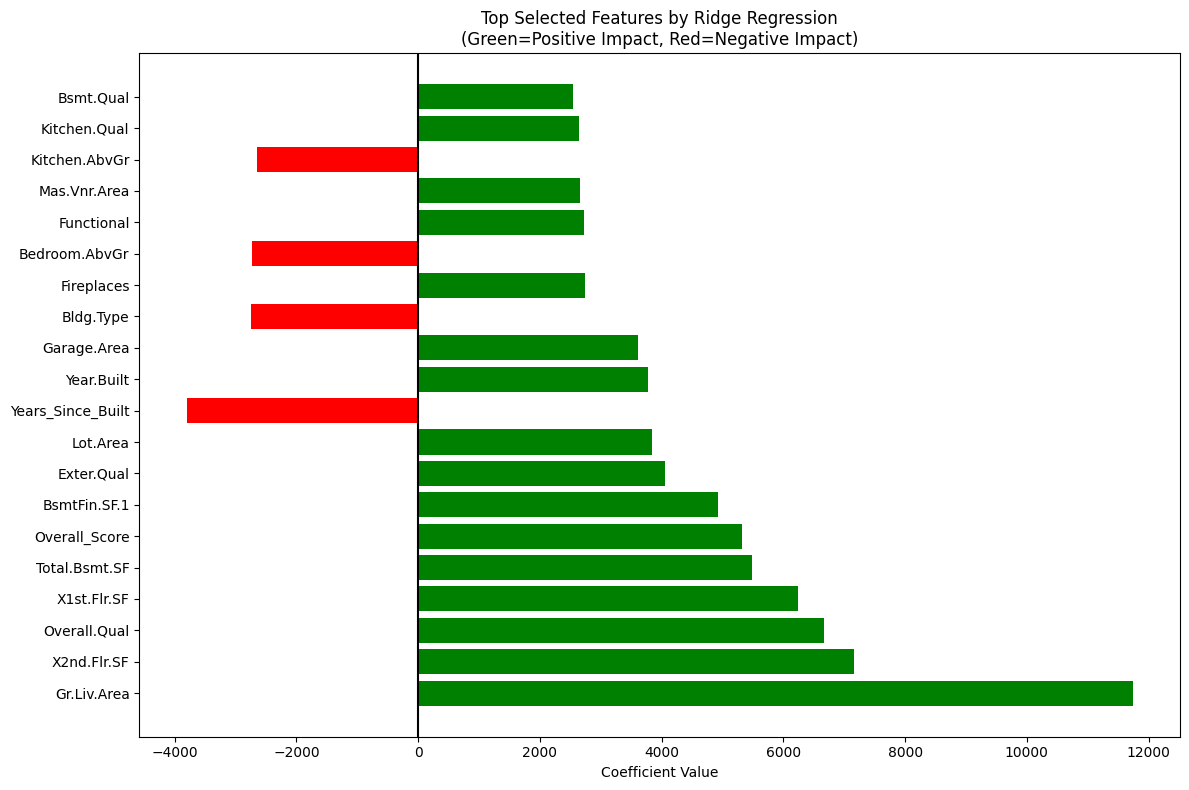

In [69]:
# --- FEATURE SELECTION ANALYSIS FOR RIDGE REGRESSION ---

# Get feature names (excluding SalePrice)
feature_names = df.drop('SalePrice', axis=1).columns

# Get coefficients from the best model
coefficients = model.coef_

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Set a threshold to determine "selected" features
# (This is arbitrary - you can adjust based on your needs)
coefficient_threshold = 0.1 * np.max(np.abs(coefficients))  # 10% of max coefficient

# Get "selected" features (those with meaningful impact)
selected_features = feature_importance[feature_importance['Abs_Coefficient'] >= coefficient_threshold]
non_selected_features = feature_importance[feature_importance['Abs_Coefficient'] < coefficient_threshold]

print(f"=== RIDGE REGRESSION FEATURE SELECTION ===")
print(f"Total features: {len(feature_importance)}")
print(f"Selected features (coefficient ≥ {coefficient_threshold:.4f}): {len(selected_features)}")
print(f"Non-selected features: {len(non_selected_features)}")
print(f"Threshold: 10% of maximum coefficient value ({np.max(np.abs(coefficients)):.4f})")

print("\n--- SELECTED FEATURES (Most Influential) ---")
print(selected_features[['Feature', 'Coefficient', 'Abs_Coefficient']].to_string(index=False))

print("\n--- NON-SELECTED FEATURES (Least Influential) ---")
print(f"Features with very small coefficients (minimal impact on price):")
print(non_selected_features['Feature'].tolist())

# Plot the selected features
plt.figure(figsize=(12, 8))
selected_for_plot = selected_features.head(20)  # Show top 20 selected features
colors = ['green' if coef > 0 else 'red' for coef in selected_for_plot['Coefficient']]
plt.barh(selected_for_plot['Feature'], selected_for_plot['Coefficient'], color=colors)
plt.axvline(x=0, color='black', linestyle='-')
plt.xlabel('Coefficient Value')
plt.title('Top Selected Features by Ridge Regression\n(Green=Positive Impact, Red=Negative Impact)')
plt.tight_layout()
plt.show()